## Hyperparameter search

Source: https://github.com/itdxer/neupy/blob/master/notebooks/Hyperparameter%20optimization%20for%20Neural%20Networks.ipynb
and http://neupy.com/2016/12/17/hyperparameter_optimization_for_neural_networks.html#id14

```python
Hyperparams to train:
1. lamda
2. number of hidden layers
3. number of hidden units
3. starter learning rate
5. use_sigmoid_h1
6. use_sigmoid_h2```

In [1]:
import time
import os
import re
import sys
import numpy as np

sys.path = sys.path[1:]
sys.path.insert(0, os.path.join(os.getcwd(), "helper_scripts"))  # pretending we are running main.py in jupyter

import global_variables_final_for_git
reload(global_variables_final_for_git)
from global_variables_final_for_git import Global_Vars
from prep_for_model_for_git import Model_preparation

import hyperopt
from hyperopt import fmin
import HPO_helper
reload(HPO_helper)
from HPO_helper import uniform_int, loguniform_int, tpe_method, get_parameter_space_forHPO
import tensorflow_model_for_git
reload(tensorflow_model_for_git)
from tensorflow_model_for_git import Tensorflow_model

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

class Args(object):
    def __init__(self):
        self.gene = "TNNC2"
        self.distance = 150
        self.use_tad_info = True
        self.pcc_lowerlimit_to_filter_dhss = 0.2
        self.filter_tfs_by = "zscore" # or "pcc"
        self.lowerlimit_to_filter_tfs = 6
        self.take_this_many_top_dhss = 6  # all dhss/tfs will already be filtered by pcc(or zscore)
        self.take_this_many_top_tfs = 10
        self.init_wts_type = "corr"
        self.outputDir = "/Users/Dinesh/Dropbox/Github/predicting_gex_with_nn_git/SIX1_new"
        self.use_random_DHSs = False
        self.use_random_TFs = False 
        self.max_iter = 100
        self.plot_all = True

###test_idx = 17 # 2 to brain; 6 to ESC; 7 is epithelial; 8 is HSC and B; 12 is muscle; 5 is ES-derived
start_time = time.time()
args = Args()
gv = Global_Vars(args, args.outputDir)  # note this takes in new_output_dir as well in .py scripts

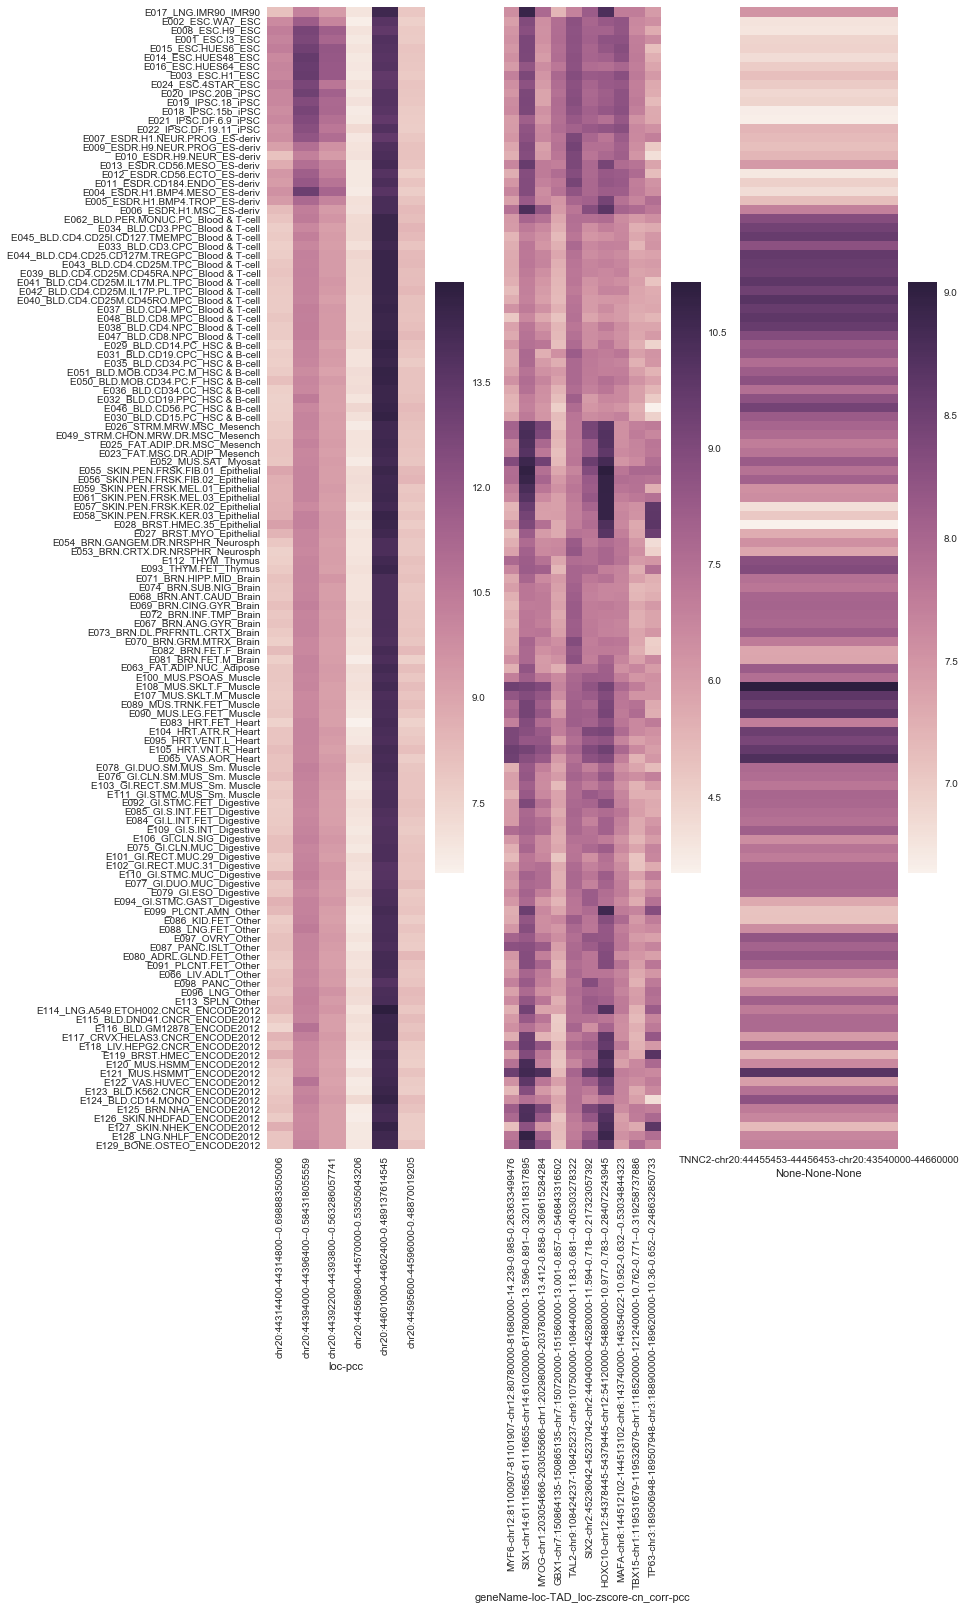

In [3]:
def plot_input_data(gv):
    plt.figure(figsize=(12, 21))
    plt.subplot(1,3,1)
    sns.heatmap(gv.df_dhss.transpose(),yticklabels=True)
    plt.subplot(1,3,2)
    sns.heatmap(gv.df_tfs.transpose(), yticklabels=False)
    plt.subplot(1,3,3)
    sns.heatmap(gv.goi.to_frame(), yticklabels=False)
    #plt.savefig(os.path.join(gv.outputDir, "input_feats_and_goi.pdf")
plot_input_data(gv)

In [4]:
'''Run HPO on differen train/test splits'''
mp = Model_preparation(gv)
start_time = time.time()

2018-01-30 15:57:46,266: prep_for_model_for_git: INFO    : Preparing the dataframe for train/test splits..


'''After updates - what i had before'''

tm.get_importance_scores(updates)

to_log, plot_title = tm.get_log_info_to_save_after_retraining(trainY, updates, title_prefix=title_prefix)  # title prefix only has mode, test group, and testX.shape infos
print(to_log)  # logger.info(to_log)
plot_title = "{};{}".format(gv.gene_ofInterest, plot_title)
tm.plot_performance_after_retraining(amode, gv, updates, trainY, plot_title=plot_title)

del tm, trials, best_params, index
del to_log, title_info, title_prefix, title_error_msg, title_suffix, plot_title
del wts, layer_sizes, lamda, trainX, trainY, b1, g1, b2, g2, updates

In [11]:
import collections as col
import copy
dict_ims = col.OrderedDict()

for amode in ["joint"]: #, "tfs", "dhss"]:
    for test_idx in range(12, 19):
        if (test_idx == 4):
            continue
        tm = Tensorflow_model(gv, mp, test_eid_group_index=test_idx, mode=amode)
        trials = hyperopt.Trials()
        best_params = hyperopt.fmin(tm.train_tensorflow_nn, trials=trials,
                                    space=get_parameter_space_forHPO(tm.trainX),
                                    algo=tpe_method, max_evals=5)

        index = np.argmin(trials.losses())
        to_log = tm.get_log_into_to_save(index, trials, best_params, mode=amode)
        print(to_log) # logger.info(to_log)

        title_info = re.split(";best_params", to_log)[0]  # "title" refers to plot_title
        title_prefix, title_error_msg, title_suffix = re.split(";median_pc_error|;PCC", title_info)  # note title_prefix already has the "mode" info
        title_info = title_prefix + "\nmed_pc_err" + title_error_msg + "\nPCC" + title_suffix
        plot_title = "{};{}".format(gv.gene_ofInterest, title_info)
        tm.plot_scatter_performance(amode, index, trials, gv, plot_title=plot_title)

        # Now retrain using the validation set
        starter_lr, use_sigmoid_h1, use_sigmoid_h2, use_sigmoid_yhat, wts, layer_sizes, lamda, trainX, trainY, b1, g1, b2, g2 = tm.get_params_from_best_trial(index, trials, best_params)  # nn_updates is the new dict, not the one in tf_model class
        updates = tm.retrain_tensorflow_nn(starter_lr, use_sigmoid_h1, use_sigmoid_h2, use_sigmoid_yhat, wts, layer_sizes, lamda, trainX, trainY, b1, g1, b2, g2)
        
        # collect the rmses
        X_ori = np.concatenate((trainX, tm.valX), axis=0)  
        Y_ori = np.concatenate((trainY, tm.valY), axis=0)  # this should not be imputed
        r_ori = tm.get_rmse(updates, use_sigmoid_h1, use_sigmoid_h2, use_sigmoid_yhat, layer_sizes, lamda, X_=X_ori, Y_ori=Y_ori)
        for i in range(0, X_ori.shape[1]):  # for all features
            X_ = copy.deepcopy(X_ori)
            X_[:,i] = 0  # mutate the feat column
            r_ = tm.get_rmse(updates, use_sigmoid_h1, use_sigmoid_h2, use_sigmoid_yhat, layer_sizes, lamda, X_=X_, Y_ori=Y_ori)  # only X is mutated 
            if (i in dict_ims.keys()):
                dict_ims[i].append(abs(r_ori - r_))
            else:
                dict_ims[i] = [abs(r_ori - r_)]
            del X_
    
        to_log, plot_title = tm.get_log_info_to_save_after_retraining(trainY, updates, title_prefix=title_prefix)  # title prefix only has mode, test group, and testX.shape infos
        print(to_log)  # logger.info(to_log)
        plot_title = "{};{}".format(gv.gene_ofInterest, plot_title)
        tm.plot_performance_after_retraining(amode, gv, updates, trainY, plot_title=plot_title)

        del tm, trials, best_params, index
        del to_log, title_info, title_prefix, title_error_msg, title_suffix, plot_title
        del wts, layer_sizes, lamda, trainX, trainY, b1, g1, b2, g2, updates
    
        print("done with mode:", amode)


lamda:5e-05, layer_sizes:[11], lr:0.007, rmse_val:0.175,                 rmse_test:0.532, use_sigmoid:[False,False,True], status:ok
lamda:0.0005, layer_sizes:[5, 6], lr:0.0007, rmse_val:0.229,                 rmse_test:0.282, use_sigmoid:[True,True,False], status:ok
lamda:0.005, layer_sizes:[5], lr:0.007, rmse_val:0.504,                 rmse_test:0.898, use_sigmoid:[True,True,False], status:ok
lamda:5e-06, layer_sizes:[11], lr:0.7, rmse_val:0.302,                 rmse_test:0.511, use_sigmoid:[False,False,True], status:ok
lamda:5e-06, layer_sizes:[11], lr:0.7, rmse_val:0.276,                 rmse_test:0.429, use_sigmoid:[False,False,True], status:ok
mode:joint;test_group_12:Muscle;testX.shape:(5, 16);median_pc_error:0.177,0.164,0.558;rmse:0.126,0.175,0.532;PCC:0.462,0.461,-0.465;SCC:0.869,0.506,-0.300;best_params:{'layers':0,'lamda':5.0,'n_units_layer_11':11.0,'starter_learning_rate':3.0,'use_sigmoid_yhat':0,'use_sigmoid_h1':1,'use_sigmoid_h2':1};test_pc_errors:0.119678052998,0.55844624

initial test rmse is 0.185 before retraining
mode:joint;test_group_17:Thymus;testX.shape:(2, 16);median_pc_error:0.146,0.377;rmse:0.087,0.317;PCC:0.863,0.859;test_pc_errors:0.135307010812,0.619486041492
('done with mode:', 'joint')
lamda:0.0005, layer_sizes:[8, 6], lr:0.0007, rmse_val:0.382,                 rmse_test:0.725, use_sigmoid:[False,True,False], status:ok
lamda:0.0005, layer_sizes:[10], lr:0.07, rmse_val:0.171,                 rmse_test:0.378, use_sigmoid:[True,True,True], status:ok
lamda:0.005, layer_sizes:[10, 6], lr:0.07, rmse_val:0.179,                 rmse_test:0.431, use_sigmoid:[False,True,False], status:ok
lamda:5e-06, layer_sizes:[11], lr:0.7, rmse_val:0.168,                 rmse_test:0.383, use_sigmoid:[True,False,True], status:ok
lamda:5e-06, layer_sizes:[11], lr:0.7, rmse_val:0.179,                 rmse_test:0.392, use_sigmoid:[True,False,True], status:ok
mode:joint;test_group_18:iPSC;testX.shape:(5, 16);median_pc_error:0.107,0.341,4.804;rmse:0.081,0.168,0.383;PCC

In [10]:
adict = dict_ims # from 8 to 11 inclusive (0 based indexing)
for k,v in adict.items():
    print(k,len(v), v)

(0, 4, [0.0066587925, 0.00053277612, 0.0079500154, 0.0050224662])
(1, 4, [0.0012267157, 0.0023483485, 0.00097648799, 0.0032420754])
(2, 4, [0.00038716942, 0.00020509958, 0.0001186803, 0.0044412017])
(3, 4, [0.0017919093, 0.0015158206, 0.0014498606, 0.003790319])
(4, 4, [0.0039739013, 0.0001296252, 0.0088003799, 0.001960218])
(5, 4, [0.00037362427, 0.00078949332, 0.001386337, 0.00058346987])
(6, 4, [0.043233477, 0.0092135817, 0.036152668, 0.004325211])
(7, 4, [0.021180645, 0.0087945312, 0.013434723, 0.005915761])
(8, 4, [0.0091721192, 0.0073656142, 0.0091525838, 0.0048410892])
(9, 4, [0.0092318505, 0.0024903119, 0.0071937293, 0.0010662079])
(10, 4, [0.0015228242, 0.00053489208, 0.00013497472, 0.0024524927])
(11, 4, [0.019476719, 0.0047390759, 0.015177488, 0.00684762])
(12, 4, [0.014280505, 0.0031297803, 0.0027508885, 0.017104387])
(13, 4, [0.0002046451, 0.0020390004, 0.00044480711, 0.00088638067])
(14, 4, [0.0095151067, 0.0010976642, 0.0047262236, 0.0015255809])
(15, 4, [0.0084168538, 0

In [8]:
# saving upto idx=7 (0-based) 
adict_to7 = dict_ims
for k,v in adict_to7.items():
    print(k,len(v), v)

(0, 8, [0.015224665, 0.0033840537, 0.0, 0.010297842, 5.748868e-05, 0.0003817156, 0.0029598996, 0.002472207])
(1, 8, [0.0062778294, 0.00033967197, 0.0, 0.0026238933, 0.0010964423, 0.001374498, 0.0042876899, 0.0021570474])
(2, 8, [0.0034249425, 5.3867698e-05, 0.0, 0.0012852773, 0.00099158287, 0.00069842488, 0.0023539811, 0.00015112758])
(3, 8, [0.0009559691, 0.0017743558, 0.0, 0.0013032928, 0.0023678839, 0.0041616186, 0.0019502416, 0.0023504198])
(4, 8, [0.00039163232, 0.0019534677, 0.0, 0.012159422, 0.00055508316, 0.0040820688, 0.014856763, 0.001693368])
(5, 8, [0.00053822994, 0.0006852597, 0.0, 0.00081842393, 0.0007095933, 0.0016770288, 0.0011497289, 0.0014318153])
(6, 8, [0.018143773, 0.004214108, 0.0, 0.050536297, 0.0056488216, 0.041602179, 0.025937408, 0.047450311])
(7, 7, [0.0090920031, 0.0017567724, 0.0, 0.022203699, 0.0044720918, 0.006667085, 0.022469379])
(8, 7, [0.012895048, 0.0040948093, 0.0, 0.0060472116, 0.0010125935, 0.004688397, 0.0076433569])
(9, 7, [0.0014486909, 0.00371

In [ ]:
###adict = {"a":[1,2,3], 1:[11,21,31]}
df = pd.DataFrame.from_dict(adict, orient='columns', dtype=None)
df_m = pd.melt(df, id_vars=["index"], value_vars=df.columns.tolist())  
# note: first 2 elements in columns list are "level_0" and index" now 
df_m.columns = ["index", "Feature", "Importance Score"]
df_m = df_m[["Feature", "Importance Score"]]

In [ ]:
sns.set(font_scale=1.5)
sns.boxplot(x="Feature", y="Importance Score", data=df_m)
plt.xticks(rotation=85)
plt.tight_layout()

In [ ]:
# - EOF - 

```python
# SINCE LAST COMMIT

'''Run HPO on differen train/test splits'''
tm = Tensorflow_model(gv, mp, test_eid_group_index=test_idx, mode = "joint")  # mode should be one of "dhss", "tfs", "joint"

plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
sns.heatmap(tm.trainX, vmin=0, vmax=1)
plt.title('trainX')
plt.subplot(2, 2, 2)
sns.heatmap(tm.trainY, vmin=0, vmax=1)
plt.title('trainY')

plt.subplot(2, 2, 3)
sns.heatmap(tm.testX, vmin=0, vmax=1)
plt.title('testX')

plt.subplot(2, 2, 4)
sns.heatmap(tm.testY, vmin=0, vmax=1)
plt.title('testY')
plt.suptitle("{}, test_idx:{}".format(gv.gene_ofInterest, test_idx))

'''Now train and search for HPO'''
trials = hyperopt.Trials()
best_params = hyperopt.fmin(tm.train_tensorflow_nn, trials=trials,
                            space=get_parameter_space_forHPO(tm.trainX),
                            algo=tpe_method, max_evals=10)
index = np.argmin(trials.losses())
to_log = tm.get_log_into_to_save(index, trials, best_params)
plot_title = re.split(";best_params", to_log)[0]
plot_title_prefix, plot_title_error_msg, plot_title_suffix = re.split(";median_pc_error|;PCC", plot_title)
plot_title = plot_title_prefix + "\nmed_pc_err" + plot_title_error_msg + "\nPCC" + plot_title_suffix
tm.plot_scatter_performance(trials, gv, gv.gene_ofInterest + ";" + plot_title)

print("Total time taken: {}".format(time.time() - start_time))

index = np.argmin(trials.losses())
plt.plot(trials.results[index]["train_loss"], color="salmon")
plt.plot(trials.results[index]["val_loss"], color="mediumvioletred")

index = np.argmin(trials.losses())
wts, layer_sizes, lamda, trainX, trainY, nn_updates, b1, g1, b2, g2 = tm.get_params_from_best_trial(index, trials, best_params)
updates = tm.retrain_tensorflow_nn(wts, layer_sizes, lamda, trainX, trainY, nn_updates, b1, g1, b2, g2)
tm.plot_performance_after_retraining(gv, updates, trainY, title_prefix=plot_title_prefix)  # need to pass in the title_prefix
```